In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil, os

!pip install split-folders
import splitfolders

## Data Manipulation

In [3]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Step 1: Load CSV and image paths
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train_df['id_code'] = train_df['id_code'] + '.png'

# Step 2: Map labels to 'NO_DR' and 'DR'
def label_mapper(x):
    return 'NO_DR' if x == 0 else 'DR'

train_df['class'] = train_df['diagnosis'].apply(label_mapper)

# Step 3: Split into train, val, test (80/10/10)
train_data, temp_data = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.2, stratify=temp_data['class'], random_state=42)

# Step 4: Define paths
image_root = '/kaggle/input/aptos2019-blindness-detection/train_images'
output_root = '/kaggle/output/split_data'

splits = {
    'train': train_data,
    'val': val_data,
    'test': test_data
}

# Step 5: Create folders and copy images
for split_name, df_split in splits.items():
    for label in ['NO_DR', 'DR']:
        split_path = os.path.join(output_root, split_name, label)
        os.makedirs(split_path, exist_ok=True)

    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f'Processing {split_name}'):
        src_path = os.path.join(image_root, row['id_code'])
        dst_path = os.path.join(output_root, split_name, row['class'], row['id_code'])
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"[Warning] Missing file: {src_path}")

Processing test: 100%|██████████| 147/147 [00:06<00:00, 24.21it/s]


In [4]:
import os

def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir("/kaggle/output/split_data")

There are 3 directories and 0 images in '/kaggle/output/split_data'.
There are 2 directories and 0 images in '/kaggle/output/split_data/test'.
There are 0 directories and 75 images in '/kaggle/output/split_data/test/DR'.
There are 0 directories and 72 images in '/kaggle/output/split_data/test/NO_DR'.
There are 2 directories and 0 images in '/kaggle/output/split_data/train'.
There are 0 directories and 1485 images in '/kaggle/output/split_data/train/DR'.
There are 0 directories and 1444 images in '/kaggle/output/split_data/train/NO_DR'.
There are 2 directories and 0 images in '/kaggle/output/split_data/val'.
There are 0 directories and 297 images in '/kaggle/output/split_data/val/DR'.
There are 0 directories and 289 images in '/kaggle/output/split_data/val/NO_DR'.


## Data Augmentation

In [5]:
import torch
from torchvision import datasets, transforms

# Define normalization (ImageNet stats)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation': transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        normalize
    ])
}

# Update root directory
input_path = '/kaggle/output/split_data/'

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(root=input_path + 'train', transform=data_transforms['train']),
    'validation': datasets.ImageFolder(root=input_path + 'val', transform=data_transforms['validation']),
    'test': datasets.ImageFolder(root=input_path + 'test', transform=data_transforms['test']),
}

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=2)
}

# Class names (to confirm mapping)
class_names = image_datasets['train'].classes
print("Class names:", class_names)  # print: ['DR', 'NO_DR']

Class names: ['DR', 'NO_DR']


## Pennylane

In [6]:
%%capture
# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

import pennylane as qml
from pennylane import numpy as np

In [7]:
n_qubits = 4                 # Number of qubits
q_depth = 10                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()

In [8]:
dev = qml.device("default.qubit", wires=n_qubits)  # a simple state simulator of qubit-based quantum circuit architectures provided by pennylane

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Creation

In [10]:
def H_layer(nqubits):
    """
      Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """
      Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """
      Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [11]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basisT
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [12]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()

        self.pre_net = nn.Linear(8,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [13]:
# Example input for visualization
example_input = torch.rand(n_qubits)
example_weights = torch.rand(q_depth * n_qubits)

# Draw the quantum circuit using qml.draw()
drawer = qml.draw(quantum_net)
print(drawer(example_input, example_weights))

0: ──H──RY(0.16)─╭●──RY(0.83)───────────╭●──RY(0.36)───────────╭●──RY(0.30)───────────╭● ···
1: ──H──RY(0.95)─╰X─╭●─────────RY(0.68)─╰X─╭●─────────RY(0.77)─╰X─╭●─────────RY(0.07)─╰X ···
2: ──H──RY(0.79)─╭●─╰X─────────RY(0.43)─╭●─╰X─────────RY(0.10)─╭●─╰X─────────RY(0.73)─╭● ···
3: ──H──RY(0.89)─╰X──RY(0.63)───────────╰X──RY(0.15)───────────╰X──RY(0.94)───────────╰X ···

0: ··· ──RY(0.49)───────────╭●──RY(0.73)───────────╭●──RY(1.00)───────────╭●──RY(0.45)────────── ···
1: ··· ─╭●─────────RY(0.06)─╰X─╭●─────────RY(0.97)─╰X─╭●─────────RY(0.41)─╰X─╭●─────────RY(0.14) ···
2: ··· ─╰X─────────RY(0.22)─╭●─╰X─────────RY(0.17)─╭●─╰X─────────RY(0.43)─╭●─╰X─────────RY(0.40) ···
3: ··· ──RY(0.06)───────────╰X──RY(0.94)───────────╰X──RY(0.08)───────────╰X──RY(0.11)────────── ···

0: ··· ─╭●──RY(0.06)───────────╭●──RY(0.56)───────────╭●──RY(0.09)───────────┤  <Z>
1: ··· ─╰X─╭●─────────RY(0.49)─╰X─╭●─────────RY(0.16)─╰X─╭●─────────RY(0.59)─┤  <Z>
2: ··· ─╭●─╰X─────────RY(0.50)─╭●─╰X─────────RY(0.31)─

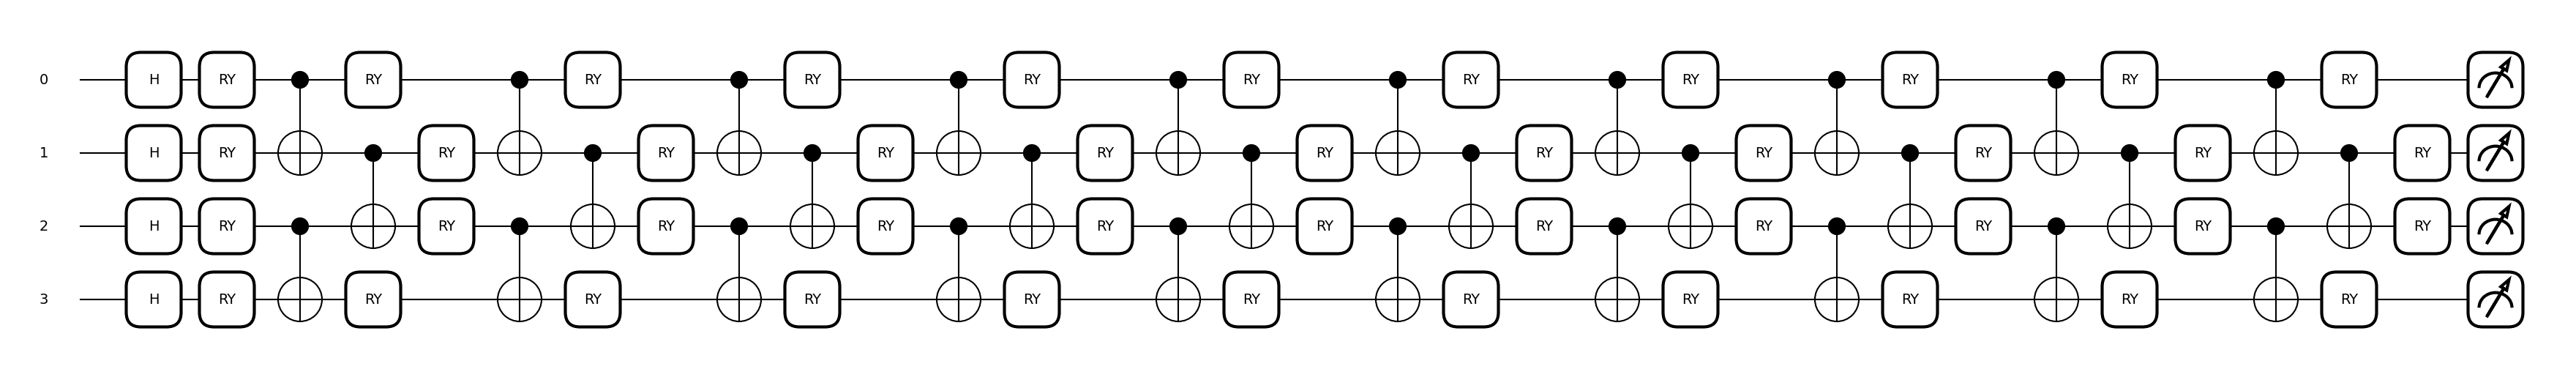

In [14]:
from matplotlib import pyplot as plt
fig, ax = qml.draw_mpl(quantum_net)(example_input, example_weights)
plt.show()

Number of parameters in the original circuit: 40


/tmp/ipykernel_36/817833314.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


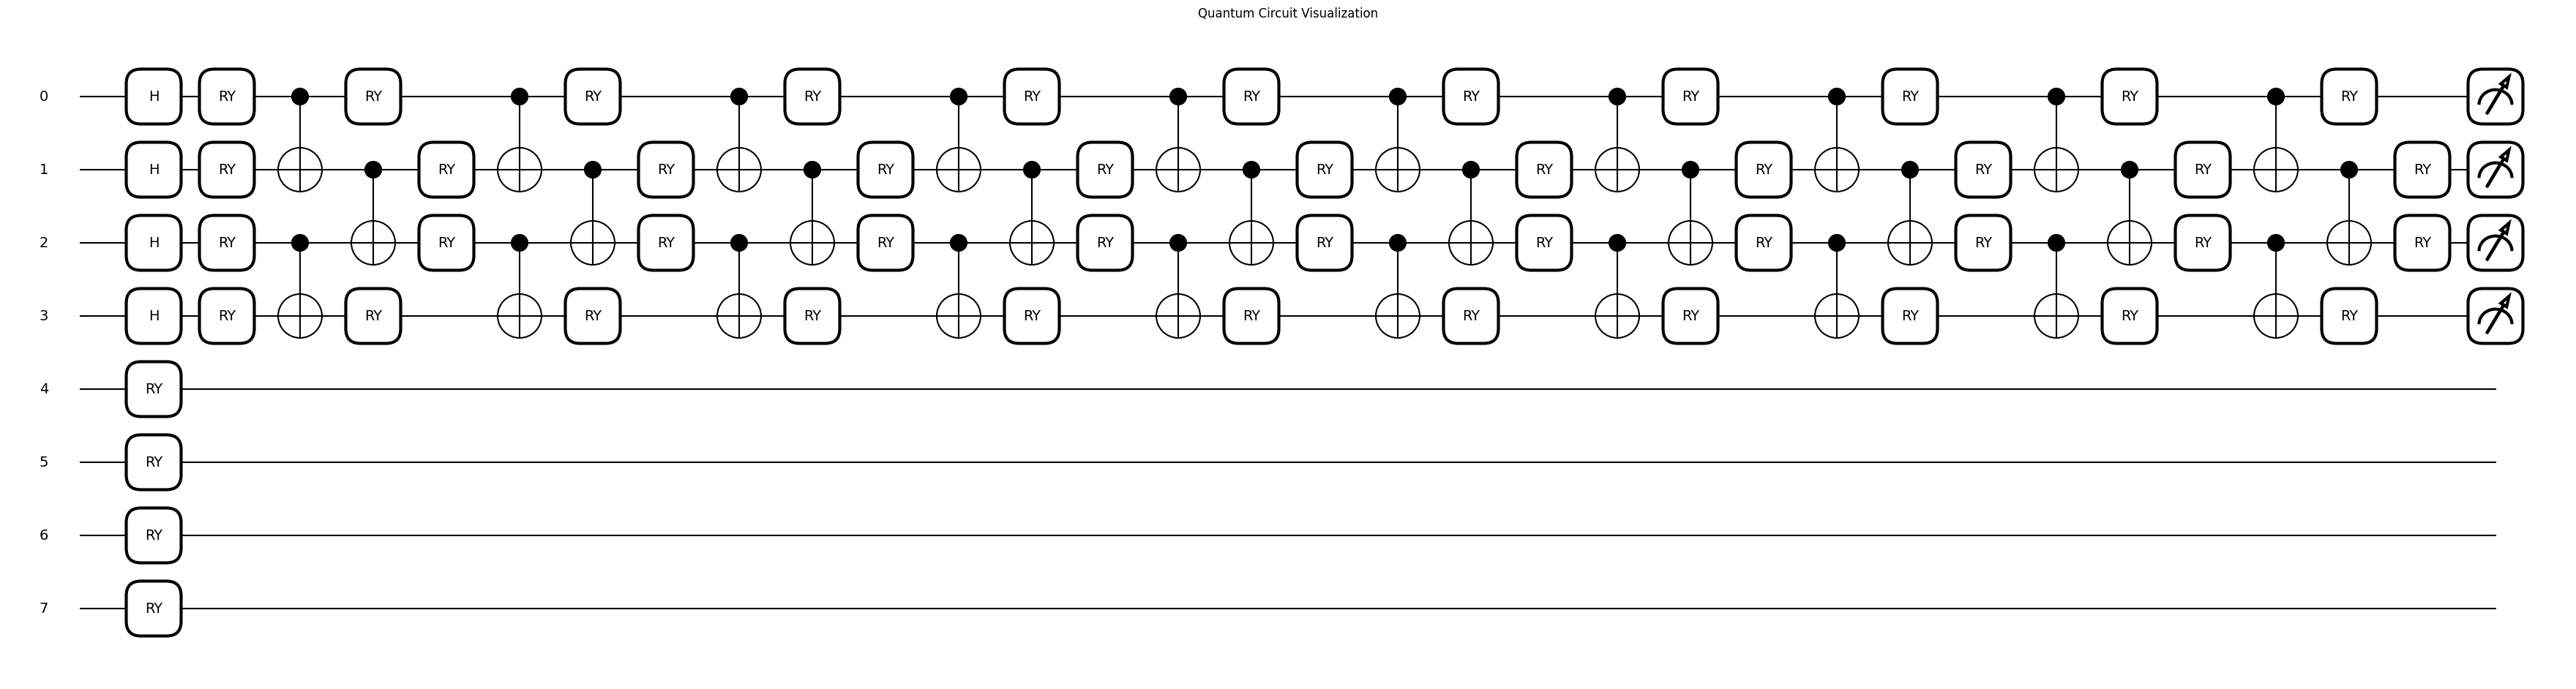

In [15]:
# Create dummy input and parameters
example_input = torch.randn(1, 8).to(device)  # Batch of 1, 8 features
example_weights = q_delta * torch.randn(q_depth * n_qubits).to(device)

# Print number of parameters
print(f"Number of parameters in the original circuit: {len(example_weights)}")

# Plot the quantum circuit
from matplotlib import pyplot as plt
fig, ax = qml.draw_mpl(quantum_net)(example_input[0], example_weights)
plt.title("Quantum Circuit Visualization")
plt.tight_layout()
plt.show()

## Custom Hybrid QCNN Model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Squeeze-and-Excitation (SE) Block
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // ratio)
        self.fc2 = nn.Linear(channels // ratio, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y


# Depthwise Separable Convolution Block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=False):
        super(DepthwiseSeparableConv, self).__init__()
        self.use_se = use_se

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                                   padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SqueezeExcitationBlock(out_channels) if use_se else nn.Identity()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.se(x)
        return x

In [17]:
# Full Custom CNN Model with Quantum Layer
class CustomModelWithQuantum(nn.Module):
    def __init__(self):
        super(CustomModelWithQuantum, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.blocks = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1, use_se=True),
            DepthwiseSeparableConv(64, 256, stride=2, use_se=True),
            DepthwiseSeparableConv(256, 256, stride=1, use_se=True),
            DepthwiseSeparableConv(256, 512, stride=2, use_se=True),
            DepthwiseSeparableConv(512, 256, stride=1, use_se=True),
            DepthwiseSeparableConv(256, 1024, stride=2, use_se=True),
            DepthwiseSeparableConv(1024, 512, stride=1, use_se=True)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.Linear(16, 8),
            DressedQuantumNet()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
model1 = CustomModelWithQuantum()

device = torch.device("cpu")
model1.to(device)

CustomModelWithQuantum(
  (initial): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SqueezeExcitationBlock(
        (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Linear(in_features=64, out_features=4, bias=True)
        (fc2): Linear(in_features=4, out_features=64, bias=True)
      )
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2

In [19]:
torch.cuda.empty_cache()

In [20]:
!pip install torchinfo

from torchinfo import summary
device = "cuda"
model1.to(device) 
summary(model1, input_size=(1, 3, 384, 384), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
CustomModelWithQuantum                        [1, 3, 384, 384]          [1, 2]                    --
├─Sequential: 1-1                             [1, 3, 384, 384]          [1, 32, 192, 192]         --
│    └─Conv2d: 2-1                            [1, 3, 384, 384]          [1, 32, 192, 192]         896
│    └─BatchNorm2d: 2-2                       [1, 32, 192, 192]         [1, 32, 192, 192]         64
│    └─ReLU: 2-3                              [1, 32, 192, 192]         [1, 32, 192, 192]         --
├─Sequential: 1-2                             [1, 32, 192, 192]         [1, 512, 24, 24]          --
│    └─DepthwiseSeparableConv: 2-4            [1, 32, 192, 192]         [1, 64, 192, 192]         --
│    │    └─Conv2d: 3-1                       [1, 32, 192, 192]         [1, 32, 192, 192]         288
│    │    └─BatchNorm2d: 3-2                  [1, 32, 192, 192]         [1, 32, 192,

## Callbacks

In [21]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, delta=0.0, restore_best_weights=True):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model_wts)
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0


def log_learning_rate(optimizer, epoch):
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"Epoch {epoch + 1}: Learning Rate = {current_lr:.6f}")

## Model Training

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Global trackers
train_acc, test_acc, train_loss, test_loss = [], [], [], []

def train_model(model, criterion, optimizer, dataloaders, image_datasets, num_epochs=30):
    early_stopping = EarlyStopping(patience=10, verbose=True, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True, min_lr=1e-6)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}  |  Accuracy: {epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc.item())

                # Apply callbacks only on validation
                log_learning_rate(optimizer, epoch)
                lr_scheduler.step(epoch_loss)
                early_stopping(epoch_loss, model)

                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    return model

    return model

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [24]:
import time 
now = time.time()

trained_model = train_model(model1, criterion, optimizer, dataloaders, image_datasets, num_epochs=70)

print(f"Total Training time: {(time.time() - now) / 3600: .4f}hrs")


Epoch 1/70
------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.5173  |  Accuracy: 0.8027
Validation Loss: 0.4305  |  Accuracy: 0.8669
Epoch 1: Learning Rate = 0.001000

Epoch 2/70
------------------------------
Train Loss: 0.4271  |  Accuracy: 0.8508
Validation Loss: 0.3145  |  Accuracy: 0.9078
Epoch 2: Learning Rate = 0.001000

Epoch 3/70
------------------------------
Train Loss: 0.3112  |  Accuracy: 0.9020
Validation Loss: 0.2368  |  Accuracy: 0.9403
Epoch 3: Learning Rate = 0.001000

Epoch 4/70
------------------------------
Train Loss: 0.2674  |  Accuracy: 0.9174
Validation Loss: 0.2352  |  Accuracy: 0.9300
Epoch 4: Learning Rate = 0.001000

Epoch 5/70
------------------------------
Train Loss: 0.2450  |  Accuracy: 0.9215
Validation Loss: 0.2093  |  Accuracy: 0.9352
Epoch 5: Learning Rate = 0.001000

Epoch 6/70
------------------------------
Train Loss: 0.2181  |  Accuracy: 0.9344
Validation Loss: 0.1867  |  Accuracy: 0.9488
Epoch 6: Learning Rate = 0.001000

Epoch 7/70
------------------------------
Train Loss: 0.2222  |  Accur

## Plotting accuracy & loss graphs

In [25]:
te_acc = []

for i in test_acc :
  te_acc.append(i)

tr_acc = []

for i in train_acc :
  tr_acc.append(i)

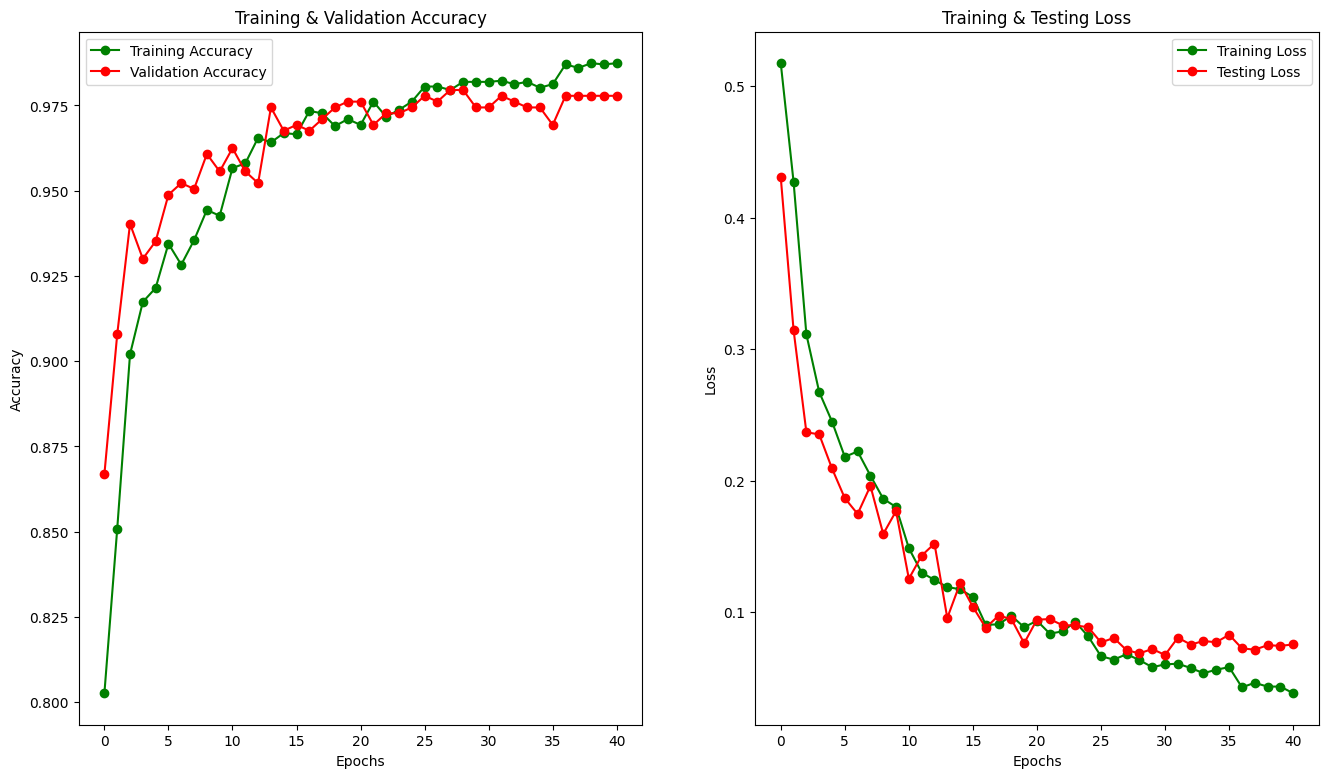

In [28]:
import matplotlib.pyplot as plt
epochs = list(range(len(train_acc)))  
fig , ax = plt.subplots(1,2)
train_acc = tr_acc
train_loss = train_loss
val_acc = te_acc
val_loss = test_loss
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [29]:
torch.save(model1.state_dict(), 'model1_final.pth')

In [30]:
phase = "validation"

y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model1(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [31]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))

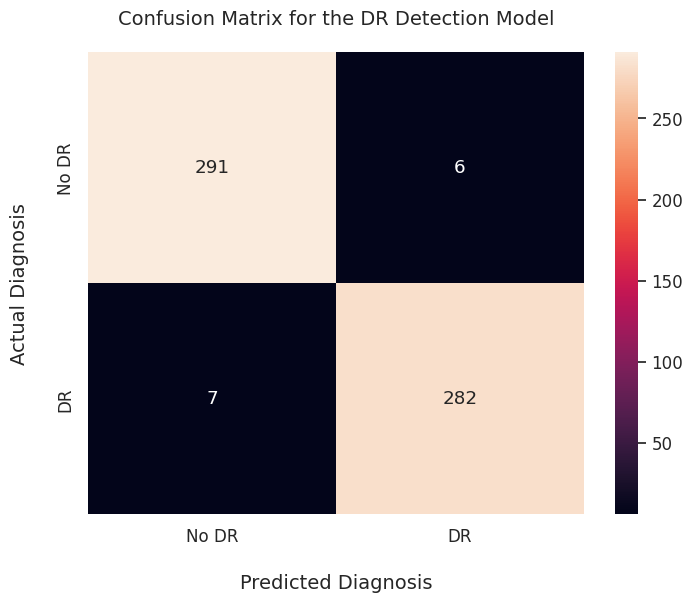

In [34]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['No DR', 'DR'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['No DR', 'DR'])

# set plot title
ax.set_title("Confusion Matrix for the DR Detection Model", fontsize=14, pad=20)

plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sn

classes = ('No DR', 'DR')

print(classification_report(y_true, y_pred, target_names=classes))

labels = np.unique(y_true)  # detects number of classes automatically
n_classes = len(labels)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Sensitivity (Recall) & Specificity
sensitivities = []
specificities = []
support = []

for i in range(n_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    sensitivities.append(sensitivity)
    specificities.append(specificity)
    support.append(np.sum(cm[i, :]))  # number of true samples in class i

# Convert support to array for weighting
support = np.array(support)
total = support.sum()

# Macro Average (unweighted mean)
macro_sensitivity = np.mean(sensitivities)
macro_specificity = np.mean(specificities)

# Weighted Average (weighted by support)
weighted_sensitivity = np.average(sensitivities, weights=support)
weighted_specificity = np.average(specificities, weights=support)

# Print results
print(f"Macro Sensitivity (Recall):     {macro_sensitivity:.4f}")
print(f"Weighted Sensitivity (Recall):  {weighted_sensitivity:.4f}")
print(f"Macro Specificity:              {macro_specificity:.4f}")
print(f"Weighted Specificity:           {weighted_specificity:.4f}")

              precision    recall  f1-score   support

       No DR       0.98      0.98      0.98       297
          DR       0.98      0.98      0.98       289

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586

ROC AUC Score: 0.9778
Macro Sensitivity (Recall):     0.9778
Weighted Sensitivity (Recall):  0.9778
Macro Specificity:              0.9778
Weighted Specificity:           0.9778


In [39]:
from sklearn.metrics import cohen_kappa_score

# Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_true, y_pred)
print(f"\nCohen's Kappa: {qwk:.4f}")

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"\nQuadratic Weighted Kappa (QWK): {qwk:.4f}")


Cohen's Kappa: 0.9556

Quadratic Weighted Kappa (QWK): 0.9556


In [40]:
phase = "test"

y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model1(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [41]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))

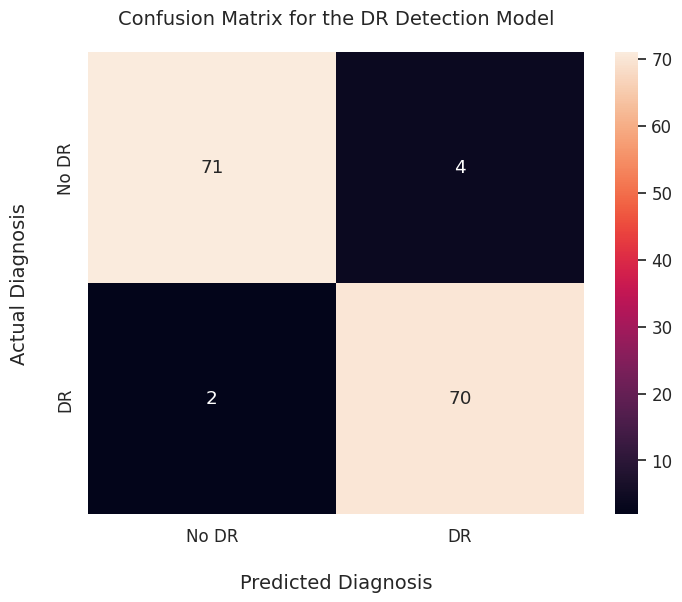

In [42]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['No DR', 'DR'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['No DR', 'DR'])

# set plot title
ax.set_title("Confusion Matrix for the DR Detection Model", fontsize=14, pad=20)

plt.show()

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

classes = ('No DR', 'DR')

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

       No DR       0.97      0.95      0.96        75
          DR       0.95      0.97      0.96        72

    accuracy                           0.96       147
   macro avg       0.96      0.96      0.96       147
weighted avg       0.96      0.96      0.96       147



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

classes = ('No DR', 'DR')

print(classification_report(y_true, y_pred, target_names=classes))

labels = np.unique(y_true)  # detects number of classes automatically
n_classes = len(labels)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Sensitivity (Recall) & Specificity
sensitivities = []
specificities = []
support = []

for i in range(n_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    sensitivities.append(sensitivity)
    specificities.append(specificity)
    support.append(np.sum(cm[i, :]))  # number of true samples in class i

# Convert support to array for weighting
support = np.array(support)
total = support.sum()

# Macro Average (unweighted mean)
macro_sensitivity = np.mean(sensitivities)
macro_specificity = np.mean(specificities)

# Weighted Average (weighted by support)
weighted_sensitivity = np.average(sensitivities, weights=support)
weighted_specificity = np.average(specificities, weights=support)

# Print results
print(f"Macro Sensitivity (Recall):     {macro_sensitivity:.4f}")
print(f"Weighted Sensitivity (Recall):  {weighted_sensitivity:.4f}")
print(f"Macro Specificity:              {macro_specificity:.4f}")
print(f"Weighted Specificity:           {weighted_specificity:.4f}")

              precision    recall  f1-score   support

       No DR       0.97      0.95      0.96        75
          DR       0.95      0.97      0.96        72

    accuracy                           0.96       147
   macro avg       0.96      0.96      0.96       147
weighted avg       0.96      0.96      0.96       147

ROC AUC Score: 0.9594
Macro Sensitivity (Recall):     0.9594
Weighted Sensitivity (Recall):  0.9592
Macro Specificity:              0.9594
Weighted Specificity:           0.9597


In [45]:
from sklearn.metrics import cohen_kappa_score

# Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_true, y_pred)
print(f"\nCohen's Kappa: {qwk:.4f}")

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"\nQuadratic Weighted Kappa (QWK): {qwk:.4f}")


Cohen's Kappa: 0.9184

Quadratic Weighted Kappa (QWK): 0.9184
